In [8]:
import xgboost
import numpy as np
import pandas as pd
import csv
import math
import random
import pickle
import matplotlib.pyplot as plt
import sklearn
from typing import Tuple
from datetime import datetime

In [9]:
training_df = pd.read_csv('train-data-10-year.csv')
y_train = training_df['price']
X_train = training_df.drop('price', axis=1)

In [10]:
training_df = pd.read_csv('test-data-10-year.csv')
y_test = training_df['price']
X_test = training_df.drop('price', axis=1)

In [4]:
def train_val_split(X, y, val_size, random_state):
    # TODO: implement your own train_val_split
    
    
    X_train = X.sample(frac = 0.9,random_state = random_state)
    X_temp = X.drop(X_train.index)
    y_train = y.sample(frac = 0.9,random_state = random_state)
    y_temp = y.drop(y_train.index)
    
    X_val = X_temp.sample(frac = 0.5,random_state = random_state)
    X_test = X_temp.drop(X_val.index)
    y_val = y_temp.sample(frac = 0.5,random_state = random_state)
    y_test = y_temp.drop(y_val.index) 
    return X_train, X_val, X_test, y_train, y_val, y_test

In [13]:
# random_state = random.getstate()[1][0]

# X_train, X_val, X_test, y_train, y_val, y_test = train_val_split(X, y, X.size, random_state)

# print(X_train)
#print(y_train)
XGB_train = xgboost.DMatrix(X_train, label=y_train)
XGB_test = xgboost.DMatrix(X_test, label=y_test)

def r2(predt: np.ndarray, dtrain: xgboost.DMatrix) -> Tuple[str, float]:
    y = dtrain.get_label()
    score = 1 - sum((y - predt)**2)/sum((y - np.mean(np.array(y)))**2)
    return 'R2', float(score)

In [11]:
#n_estimators
#minchildweight[i for i in range(10)]以及max_depth[i for i in range(10)]
#gamma[0,inf]
#subsample(0.5,1]以及colsample_bytree(0,1]
#regalpha[0,inf]以及reglambda[0,inf]
#learning_rate(0,inf]
#initparams = {'learning_rate': 0.1,  'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
#                    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}
params = {'learning_rate': 0.1,  'max_depth': 8, 'min_child_weight': 1, 'seed': 0,
                    'subsample': 0.6, 'colsample_bytree': 0.9, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 16}

In [51]:
XGB_train = xgboost.DMatrix(X_train, label=y_train)
XGB_test = xgboost.DMatrix(X_test, label=y_test)

def r2(predt: np.ndarray, dtrain: xgboost.DMatrix) -> Tuple[str, float]:
    y = dtrain.get_label()
    score = 1 - sum((y - predt)**2)/sum((y - np.mean(np.array(y)))**2)
    return 'R2', float(score)

gridsearch_params = [
    (i, j)
    for i in [0]
    for j in [16]
]
gridsearch1 = 'reg_alpha'
gridsearch2 = 'reg_lambda'


plot_dict = {}
from sklearn.metrics import r2_score

for i,j in gridsearch_params:
    currentDateAndTime = datetime.now()
    print("now:",i,j)
    params[gridsearch1] = i
    params[gridsearch2] = j
    #early_stop = xgboost.callback.EarlyStopping(rounds=20,metric_name='rmse')
    xgbcv = xgboost.cv(
        params,
        XGB_train,
        nfold=5,
        custom_metric=r2,
        num_boost_round = 2000#,
        #callbacks = [early_stop]
    )
    print(xgbcv)
    plot_dict[(i,j)] = (xgbcv['test-R2-mean'],xgbcv['train-R2-mean'])
    print(xgbcv['test-R2-mean'].max())
    print("time:",datetime.now()-currentDateAndTime)

now: 0 16
      train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std  \
0        9.992286e+06    10691.104409    9.992960e+06   41363.894387   
1        9.089740e+06    15798.699496    9.091540e+06   40781.577026   
2        8.274513e+06    12948.046453    8.277775e+06   40604.431092   
3        7.540112e+06    11066.279287    7.545561e+06   40155.259484   
4        6.889092e+06    11914.685732    6.897073e+06   36188.381227   
...               ...             ...             ...            ...   
1995     4.677382e+05     4321.261982    1.513355e+06   31693.882830   
1996     4.676403e+05     4337.649314    1.513375e+06   31699.772255   
1997     4.675216e+05     4357.768948    1.513404e+06   31690.361801   
1998     4.673993e+05     4346.394044    1.513375e+06   31677.063687   
1999     4.672867e+05     4347.744029    1.513349e+06   31678.743952   

      train-R2-mean  train-R2-std  test-R2-mean  test-R2-std  
0         -2.443396      0.006104     -2.444215     0.022315  

In [29]:
#print(plot_dict)
for i,j in plot_dict:
    print(i,j)
    plt.figure(figsize=(4, 2))
    plt.plot(np.squeeze(plot_dict[(i,j)][1][-1000:]-plot_dict[(i,j)][0][-1000:]))
    plt.ylabel('r2_diff')
    plt.xlabel('iterations')
    plt.show()
    plt.figure(figsize=(4, 2))
    plt.plot(np.squeeze(plot_dict[(i,j)][1][500:]))
    plt.plot(np.squeeze(plot_dict[(i,j)][0][500:]))
    plt.ylabel('r2')
    plt.xlabel('iterations')
    plt.show()

plt.figure(figsize=(4, 2))
for i,j in plot_dict:
    if(plot_dict[(i,j)][0].max()<0.915):
        continue
    plt.plot(np.squeeze(plot_dict[(i,j)][0][300:]),label = (i,j))
    plt.legend(
    loc='upper center', bbox_to_anchor=(0.5, -0.05),
    fontsize=10,
    shadow=True,
    facecolor='#ccc',
    edgecolor='#000',
    title='test',
    title_fontsize=20)
plt.ylabel('r2')
plt.xlabel('iterations')
plt.show()

for i,j in plot_dict:
    if(plot_dict[(i,j)][0].max()<0.915):
        continue
    plt.plot(np.squeeze(plot_dict[(i,j)][0][300:] - np.squeeze(plot_dict[(i,j)][1][300:])),label = (i,j))
    plt.legend(
    loc='upper center', bbox_to_anchor=(0.5, -0.05),
    fontsize=10,
    shadow=True,
    facecolor='#ccc',
    edgecolor='#000',
    title='test',
    title_fontsize=20)
plt.ylabel('r2')
plt.xlabel('iterations')
plt.show()

ValueError: too many values to unpack (expected 2)

In [39]:
plot_dict_eval = {}
class XGBLogging(xgboost.callback.TrainingCallback):
    """log train logs to file"""

    def __init__(self, epoch_log_interval=1):
        self.epoch_log_interval = epoch_log_interval

    def after_iteration(self, model, epoch, evals_log):
        if epoch == self.epoch_log_interval - 1:
            for data, metric in evals_log.items():
                plot_dict_eval[data + '-R2'] = metric["R2"]
        # False to indicate training should not stop.
        return False


xgbrt = xgboost.train(params,
        dtrain = XGB_train,
        #5000,
        evals = [(XGB_test,'test'), (XGB_train,'train')],
        num_boost_round = 5000,
        custom_metric=r2,
        callbacks=[XGBLogging(epoch_log_interval=5000)]
        #feval = r2
        )
print(max(plot_dict_eval['test-R2']))

[0]	test-rmse:10061392.72552	test-R2:-2.53701	train-rmse:9988736.40656	train-R2:-2.44093
[1]	test-rmse:9144829.44616	test-R2:-1.92194	train-rmse:9080061.94412	train-R2:-1.84336
[2]	test-rmse:8318607.24156	test-R2:-1.41780	train-rmse:8260375.94096	train-R2:-1.35317
[3]	test-rmse:7578733.07200	test-R2:-1.00684	train-rmse:7526325.42560	train-R2:-0.95353
[4]	test-rmse:6920688.86405	test-R2:-0.67347	train-rmse:6871161.07799	train-R2:-0.62823
[5]	test-rmse:6331831.78602	test-R2:-0.40081	train-rmse:6281192.24737	train-R2:-0.36062
[6]	test-rmse:5805787.72796	test-R2:-0.17772	train-rmse:5756154.02614	train-R2:-0.14266
[7]	test-rmse:5348135.31228	test-R2:0.00063	train-rmse:5301154.80792	train-R2:0.03084
[8]	test-rmse:4940663.00624	test-R2:0.14711	train-rmse:4893709.26985	train-R2:0.17409
[9]	test-rmse:4568342.32606	test-R2:0.27082	train-rmse:4518876.33396	train-R2:0.29577
[10]	test-rmse:4246008.92871	test-R2:0.37008	train-rmse:4193041.59673	train-R2:0.39366
[11]	test-rmse:3964410.79100	test-R2:0

[95]	test-rmse:1739245.73837	test-R2:0.89431	train-rmse:1455225.72281	train-R2:0.92697
[96]	test-rmse:1735483.56244	test-R2:0.89477	train-rmse:1450416.74939	train-R2:0.92745
[97]	test-rmse:1733630.47791	test-R2:0.89499	train-rmse:1447484.85488	train-R2:0.92774
[98]	test-rmse:1732890.78752	test-R2:0.89508	train-rmse:1445901.59871	train-R2:0.92790
[99]	test-rmse:1732055.98231	test-R2:0.89518	train-rmse:1443780.20298	train-R2:0.92811
[100]	test-rmse:1731533.72337	test-R2:0.89524	train-rmse:1442381.39971	train-R2:0.92825
[101]	test-rmse:1731789.63775	test-R2:0.89521	train-rmse:1441397.16171	train-R2:0.92835
[102]	test-rmse:1728119.59318	test-R2:0.89566	train-rmse:1437219.38761	train-R2:0.92876
[103]	test-rmse:1726543.95766	test-R2:0.89585	train-rmse:1434632.35098	train-R2:0.92902
[104]	test-rmse:1725241.98477	test-R2:0.89600	train-rmse:1431195.21452	train-R2:0.92936
[105]	test-rmse:1724607.16900	test-R2:0.89608	train-rmse:1429122.55542	train-R2:0.92956
[106]	test-rmse:1724226.33200	test-R2

[189]	test-rmse:1649080.74261	test-R2:0.90498	train-rmse:1280617.35262	train-R2:0.94344
[190]	test-rmse:1647569.98207	test-R2:0.90516	train-rmse:1277424.78068	train-R2:0.94372
[191]	test-rmse:1647063.28445	test-R2:0.90521	train-rmse:1276547.68338	train-R2:0.94380
[192]	test-rmse:1645972.51126	test-R2:0.90534	train-rmse:1275145.40686	train-R2:0.94392
[193]	test-rmse:1645282.78976	test-R2:0.90542	train-rmse:1273931.49252	train-R2:0.94403
[194]	test-rmse:1644968.71255	test-R2:0.90546	train-rmse:1273046.24321	train-R2:0.94411
[195]	test-rmse:1643494.27597	test-R2:0.90563	train-rmse:1271063.20719	train-R2:0.94428
[196]	test-rmse:1642687.24323	test-R2:0.90572	train-rmse:1269734.12777	train-R2:0.94440
[197]	test-rmse:1641587.27743	test-R2:0.90584	train-rmse:1268242.50306	train-R2:0.94453
[198]	test-rmse:1640395.19575	test-R2:0.90598	train-rmse:1266845.01398	train-R2:0.94465
[199]	test-rmse:1640282.79048	test-R2:0.90599	train-rmse:1266105.13240	train-R2:0.94472
[200]	test-rmse:1639738.05267	te

[283]	test-rmse:1597744.76761	test-R2:0.91081	train-rmse:1155206.90227	train-R2:0.95398
[284]	test-rmse:1597221.04818	test-R2:0.91087	train-rmse:1154336.38110	train-R2:0.95405
[285]	test-rmse:1596852.02420	test-R2:0.91091	train-rmse:1153302.25900	train-R2:0.95413
[286]	test-rmse:1596928.93911	test-R2:0.91090	train-rmse:1152219.48505	train-R2:0.95422
[287]	test-rmse:1596557.06695	test-R2:0.91094	train-rmse:1151660.48087	train-R2:0.95426
[288]	test-rmse:1596213.81604	test-R2:0.91098	train-rmse:1150635.22437	train-R2:0.95434
[289]	test-rmse:1595961.55036	test-R2:0.91100	train-rmse:1150438.05568	train-R2:0.95436
[290]	test-rmse:1595310.59820	test-R2:0.91108	train-rmse:1149346.57122	train-R2:0.95444
[291]	test-rmse:1595085.58904	test-R2:0.91110	train-rmse:1148455.52352	train-R2:0.95451
[292]	test-rmse:1594935.69781	test-R2:0.91112	train-rmse:1147407.29117	train-R2:0.95460
[293]	test-rmse:1595201.73252	test-R2:0.91109	train-rmse:1146101.84364	train-R2:0.95470
[294]	test-rmse:1594953.14494	te

[377]	test-rmse:1572326.62532	test-R2:0.91362	train-rmse:1058144.09585	train-R2:0.96139
[378]	test-rmse:1572111.40032	test-R2:0.91365	train-rmse:1057480.42178	train-R2:0.96144
[379]	test-rmse:1572198.68660	test-R2:0.91364	train-rmse:1056576.20027	train-R2:0.96150
[380]	test-rmse:1572337.62028	test-R2:0.91362	train-rmse:1055871.51194	train-R2:0.96155
[381]	test-rmse:1571923.99162	test-R2:0.91367	train-rmse:1054106.44946	train-R2:0.96168
[382]	test-rmse:1570935.25645	test-R2:0.91377	train-rmse:1052697.11531	train-R2:0.96178
[383]	test-rmse:1571010.47238	test-R2:0.91377	train-rmse:1051821.78786	train-R2:0.96185
[384]	test-rmse:1570866.80768	test-R2:0.91378	train-rmse:1051673.45638	train-R2:0.96186
[385]	test-rmse:1570509.97476	test-R2:0.91382	train-rmse:1050310.05598	train-R2:0.96196
[386]	test-rmse:1570404.51381	test-R2:0.91383	train-rmse:1049269.53309	train-R2:0.96203
[387]	test-rmse:1570332.46725	test-R2:0.91384	train-rmse:1048927.65710	train-R2:0.96206
[388]	test-rmse:1569440.09168	te

[471]	test-rmse:1550031.27150	test-R2:0.91605	train-rmse:978897.10568	train-R2:0.96695
[472]	test-rmse:1549628.92114	test-R2:0.91610	train-rmse:978034.88011	train-R2:0.96701
[473]	test-rmse:1549688.02090	test-R2:0.91609	train-rmse:977187.36688	train-R2:0.96707
[474]	test-rmse:1549607.31460	test-R2:0.91610	train-rmse:976699.55463	train-R2:0.96710
[475]	test-rmse:1549740.79458	test-R2:0.91609	train-rmse:975627.03227	train-R2:0.96717
[476]	test-rmse:1549924.30597	test-R2:0.91607	train-rmse:975194.86018	train-R2:0.96720
[477]	test-rmse:1549922.63619	test-R2:0.91607	train-rmse:974647.96214	train-R2:0.96724
[478]	test-rmse:1549883.72478	test-R2:0.91607	train-rmse:974113.20831	train-R2:0.96727
[479]	test-rmse:1549284.59845	test-R2:0.91614	train-rmse:972840.67060	train-R2:0.96736
[480]	test-rmse:1549115.87669	test-R2:0.91615	train-rmse:971968.34483	train-R2:0.96742
[481]	test-rmse:1548918.65825	test-R2:0.91617	train-rmse:971637.29384	train-R2:0.96744
[482]	test-rmse:1548811.09815	test-R2:0.916

[566]	test-rmse:1535565.98756	test-R2:0.91761	train-rmse:912434.30931	train-R2:0.97129
[567]	test-rmse:1535375.29791	test-R2:0.91763	train-rmse:911875.10066	train-R2:0.97132
[568]	test-rmse:1535237.22003	test-R2:0.91765	train-rmse:911143.32891	train-R2:0.97137
[569]	test-rmse:1534926.06417	test-R2:0.91768	train-rmse:910888.77001	train-R2:0.97139
[570]	test-rmse:1534905.38851	test-R2:0.91768	train-rmse:910609.79614	train-R2:0.97140
[571]	test-rmse:1534806.78593	test-R2:0.91770	train-rmse:910236.06919	train-R2:0.97143
[572]	test-rmse:1534788.72406	test-R2:0.91770	train-rmse:909687.99108	train-R2:0.97146
[573]	test-rmse:1534803.49052	test-R2:0.91770	train-rmse:909310.95658	train-R2:0.97149
[574]	test-rmse:1534564.29806	test-R2:0.91772	train-rmse:908725.24231	train-R2:0.97152
[575]	test-rmse:1534598.89793	test-R2:0.91772	train-rmse:908235.18085	train-R2:0.97155
[576]	test-rmse:1534745.43654	test-R2:0.91770	train-rmse:907454.27733	train-R2:0.97160
[577]	test-rmse:1534676.31539	test-R2:0.917

[661]	test-rmse:1526183.73725	test-R2:0.91862	train-rmse:857706.90313	train-R2:0.97463
[662]	test-rmse:1526557.35595	test-R2:0.91858	train-rmse:856841.79912	train-R2:0.97468
[663]	test-rmse:1526489.76763	test-R2:0.91858	train-rmse:856110.66660	train-R2:0.97472
[664]	test-rmse:1526725.05286	test-R2:0.91856	train-rmse:855614.19062	train-R2:0.97475
[665]	test-rmse:1526851.00631	test-R2:0.91855	train-rmse:854826.14811	train-R2:0.97480
[666]	test-rmse:1526878.17380	test-R2:0.91854	train-rmse:854659.74836	train-R2:0.97481
[667]	test-rmse:1527053.59593	test-R2:0.91852	train-rmse:854295.49126	train-R2:0.97483
[668]	test-rmse:1527104.28719	test-R2:0.91852	train-rmse:853651.61232	train-R2:0.97487
[669]	test-rmse:1527203.69619	test-R2:0.91851	train-rmse:853062.33985	train-R2:0.97490
[670]	test-rmse:1527143.44371	test-R2:0.91851	train-rmse:852767.46786	train-R2:0.97492
[671]	test-rmse:1526977.33779	test-R2:0.91853	train-rmse:852316.05759	train-R2:0.97495
[672]	test-rmse:1527087.50332	test-R2:0.918

[755]	test-rmse:1521673.70747	test-R2:0.91910	train-rmse:811800.57406	train-R2:0.97727
[756]	test-rmse:1521539.93212	test-R2:0.91911	train-rmse:811593.51073	train-R2:0.97728
[757]	test-rmse:1521609.93846	test-R2:0.91910	train-rmse:811070.42204	train-R2:0.97731
[758]	test-rmse:1521370.17162	test-R2:0.91913	train-rmse:810591.81885	train-R2:0.97734
[759]	test-rmse:1521126.05008	test-R2:0.91916	train-rmse:810253.23385	train-R2:0.97736
[760]	test-rmse:1520938.73202	test-R2:0.91917	train-rmse:810094.58061	train-R2:0.97737
[761]	test-rmse:1520719.84307	test-R2:0.91920	train-rmse:809686.02102	train-R2:0.97739
[762]	test-rmse:1520777.06159	test-R2:0.91919	train-rmse:809123.20516	train-R2:0.97742
[763]	test-rmse:1520585.76054	test-R2:0.91921	train-rmse:808632.37692	train-R2:0.97745
[764]	test-rmse:1520447.67859	test-R2:0.91923	train-rmse:807987.38413	train-R2:0.97749
[765]	test-rmse:1520424.82422	test-R2:0.91923	train-rmse:807799.82774	train-R2:0.97750
[766]	test-rmse:1520242.84146	test-R2:0.919

[850]	test-rmse:1515362.51286	test-R2:0.91977	train-rmse:771872.22749	train-R2:0.97945
[851]	test-rmse:1515494.76875	test-R2:0.91975	train-rmse:771406.85838	train-R2:0.97948
[852]	test-rmse:1515548.13252	test-R2:0.91975	train-rmse:770987.30925	train-R2:0.97950
[853]	test-rmse:1515763.41869	test-R2:0.91973	train-rmse:770419.30742	train-R2:0.97953
[854]	test-rmse:1515732.98488	test-R2:0.91973	train-rmse:770013.82652	train-R2:0.97955
[855]	test-rmse:1515692.88823	test-R2:0.91973	train-rmse:769735.72304	train-R2:0.97957
[856]	test-rmse:1515574.49920	test-R2:0.91975	train-rmse:769361.50444	train-R2:0.97959
[857]	test-rmse:1515680.40947	test-R2:0.91973	train-rmse:768926.27006	train-R2:0.97961
[858]	test-rmse:1515506.76661	test-R2:0.91975	train-rmse:768476.62922	train-R2:0.97963
[859]	test-rmse:1515349.11538	test-R2:0.91977	train-rmse:767751.99068	train-R2:0.97967
[860]	test-rmse:1515214.09619	test-R2:0.91978	train-rmse:767221.04762	train-R2:0.97970
[861]	test-rmse:1515052.84293	test-R2:0.919

[945]	test-rmse:1511128.72508	test-R2:0.92022	train-rmse:735504.79566	train-R2:0.98134
[946]	test-rmse:1511198.85586	test-R2:0.92021	train-rmse:734960.42546	train-R2:0.98137
[947]	test-rmse:1511139.59688	test-R2:0.92021	train-rmse:734560.31727	train-R2:0.98139
[948]	test-rmse:1511094.45443	test-R2:0.92022	train-rmse:734157.91084	train-R2:0.98141
[949]	test-rmse:1510900.03845	test-R2:0.92024	train-rmse:733910.39363	train-R2:0.98142
[950]	test-rmse:1510841.84438	test-R2:0.92024	train-rmse:733525.17070	train-R2:0.98144
[951]	test-rmse:1510680.53850	test-R2:0.92026	train-rmse:732978.46248	train-R2:0.98147
[952]	test-rmse:1510914.66547	test-R2:0.92024	train-rmse:732671.00891	train-R2:0.98149
[953]	test-rmse:1511034.85972	test-R2:0.92022	train-rmse:732359.30287	train-R2:0.98150
[954]	test-rmse:1511145.21753	test-R2:0.92021	train-rmse:731942.98774	train-R2:0.98152
[955]	test-rmse:1511135.57820	test-R2:0.92021	train-rmse:731712.61729	train-R2:0.98154
[956]	test-rmse:1511211.35232	test-R2:0.920

[1039]	test-rmse:1509154.92923	test-R2:0.92042	train-rmse:703957.71940	train-R2:0.98291
[1040]	test-rmse:1509165.13247	test-R2:0.92042	train-rmse:703672.74735	train-R2:0.98292
[1041]	test-rmse:1509340.30956	test-R2:0.92040	train-rmse:703296.06162	train-R2:0.98294
[1042]	test-rmse:1509491.98762	test-R2:0.92039	train-rmse:702868.17888	train-R2:0.98296
[1043]	test-rmse:1509325.85333	test-R2:0.92041	train-rmse:702641.16624	train-R2:0.98297
[1044]	test-rmse:1509458.65350	test-R2:0.92039	train-rmse:702272.06954	train-R2:0.98299
[1045]	test-rmse:1509367.66461	test-R2:0.92040	train-rmse:701985.97098	train-R2:0.98301
[1046]	test-rmse:1509477.03284	test-R2:0.92039	train-rmse:701641.56630	train-R2:0.98302
[1047]	test-rmse:1509378.15276	test-R2:0.92040	train-rmse:701266.85793	train-R2:0.98304
[1048]	test-rmse:1509305.56461	test-R2:0.92041	train-rmse:700877.40828	train-R2:0.98306
[1049]	test-rmse:1509362.24038	test-R2:0.92040	train-rmse:700635.60719	train-R2:0.98307
[1050]	test-rmse:1509358.74403	t

[1133]	test-rmse:1507042.34863	test-R2:0.92065	train-rmse:675532.04701	train-R2:0.98426
[1134]	test-rmse:1507171.06585	test-R2:0.92063	train-rmse:675319.86663	train-R2:0.98427
[1135]	test-rmse:1507211.54612	test-R2:0.92063	train-rmse:675151.48900	train-R2:0.98428
[1136]	test-rmse:1507220.42055	test-R2:0.92063	train-rmse:674889.72426	train-R2:0.98429
[1137]	test-rmse:1507217.58051	test-R2:0.92063	train-rmse:674677.51852	train-R2:0.98430
[1138]	test-rmse:1507232.58572	test-R2:0.92063	train-rmse:674471.44341	train-R2:0.98431
[1139]	test-rmse:1507187.37841	test-R2:0.92063	train-rmse:674227.90406	train-R2:0.98432
[1140]	test-rmse:1507076.97415	test-R2:0.92064	train-rmse:673978.19428	train-R2:0.98433
[1141]	test-rmse:1507165.57144	test-R2:0.92063	train-rmse:673669.68083	train-R2:0.98435
[1142]	test-rmse:1507136.29758	test-R2:0.92064	train-rmse:673448.36758	train-R2:0.98436
[1143]	test-rmse:1507201.38550	test-R2:0.92063	train-rmse:673184.92593	train-R2:0.98437
[1144]	test-rmse:1507128.79274	t

[1227]	test-rmse:1505861.56667	test-R2:0.92077	train-rmse:650775.16838	train-R2:0.98540
[1228]	test-rmse:1505828.98213	test-R2:0.92077	train-rmse:650684.64103	train-R2:0.98540
[1229]	test-rmse:1505775.33280	test-R2:0.92078	train-rmse:650420.20779	train-R2:0.98541
[1230]	test-rmse:1505873.79343	test-R2:0.92077	train-rmse:650065.48626	train-R2:0.98543
[1231]	test-rmse:1505673.48577	test-R2:0.92079	train-rmse:649574.40235	train-R2:0.98545
[1232]	test-rmse:1505643.32456	test-R2:0.92079	train-rmse:649353.56708	train-R2:0.98546
[1233]	test-rmse:1505465.79124	test-R2:0.92081	train-rmse:649155.37702	train-R2:0.98547
[1234]	test-rmse:1505265.92171	test-R2:0.92083	train-rmse:648828.84324	train-R2:0.98548
[1235]	test-rmse:1505495.59613	test-R2:0.92081	train-rmse:648613.16579	train-R2:0.98549
[1236]	test-rmse:1505596.15794	test-R2:0.92080	train-rmse:648307.90382	train-R2:0.98550
[1237]	test-rmse:1505578.59455	test-R2:0.92080	train-rmse:648105.35952	train-R2:0.98551
[1238]	test-rmse:1505598.49592	t

[1320]	test-rmse:1503940.81638	test-R2:0.92097	train-rmse:627908.40553	train-R2:0.98640
[1321]	test-rmse:1504042.77944	test-R2:0.92096	train-rmse:627710.00664	train-R2:0.98641
[1322]	test-rmse:1504036.57617	test-R2:0.92096	train-rmse:627603.26566	train-R2:0.98642
[1323]	test-rmse:1504079.53502	test-R2:0.92096	train-rmse:627412.74307	train-R2:0.98642
[1324]	test-rmse:1504046.21591	test-R2:0.92096	train-rmse:627162.35671	train-R2:0.98643
[1325]	test-rmse:1503897.29557	test-R2:0.92098	train-rmse:626830.74872	train-R2:0.98645
[1326]	test-rmse:1503874.40039	test-R2:0.92098	train-rmse:626652.10906	train-R2:0.98646
[1327]	test-rmse:1503744.83248	test-R2:0.92099	train-rmse:626443.98053	train-R2:0.98647
[1328]	test-rmse:1503593.69953	test-R2:0.92101	train-rmse:626333.85957	train-R2:0.98647
[1329]	test-rmse:1503459.19190	test-R2:0.92102	train-rmse:625965.16715	train-R2:0.98649
[1330]	test-rmse:1503431.29294	test-R2:0.92102	train-rmse:625835.53113	train-R2:0.98649
[1331]	test-rmse:1503474.11078	t

[1414]	test-rmse:1502968.41588	test-R2:0.92107	train-rmse:606995.15966	train-R2:0.98729
[1415]	test-rmse:1502967.67101	test-R2:0.92107	train-rmse:606838.04549	train-R2:0.98730
[1416]	test-rmse:1503013.33942	test-R2:0.92107	train-rmse:606633.68047	train-R2:0.98731
[1417]	test-rmse:1503117.14826	test-R2:0.92106	train-rmse:606419.16491	train-R2:0.98732
[1418]	test-rmse:1503055.63043	test-R2:0.92107	train-rmse:606207.85137	train-R2:0.98733
[1419]	test-rmse:1503028.02736	test-R2:0.92107	train-rmse:605994.32523	train-R2:0.98733
[1420]	test-rmse:1502992.26403	test-R2:0.92107	train-rmse:605755.69424	train-R2:0.98735
[1421]	test-rmse:1503123.14688	test-R2:0.92106	train-rmse:605511.80640	train-R2:0.98736
[1422]	test-rmse:1502975.88345	test-R2:0.92107	train-rmse:605397.99220	train-R2:0.98736
[1423]	test-rmse:1502972.94006	test-R2:0.92107	train-rmse:605028.88760	train-R2:0.98738
[1424]	test-rmse:1503164.69109	test-R2:0.92105	train-rmse:604794.76587	train-R2:0.98738
[1425]	test-rmse:1503153.93230	t

[1508]	test-rmse:1502963.97178	test-R2:0.92107	train-rmse:588373.59027	train-R2:0.98806
[1509]	test-rmse:1502986.31411	test-R2:0.92107	train-rmse:588208.48897	train-R2:0.98807
[1510]	test-rmse:1502989.74489	test-R2:0.92107	train-rmse:587994.05957	train-R2:0.98808
[1511]	test-rmse:1502851.46316	test-R2:0.92109	train-rmse:587793.28424	train-R2:0.98808
[1512]	test-rmse:1502742.67730	test-R2:0.92110	train-rmse:587597.19132	train-R2:0.98809
[1513]	test-rmse:1502812.77533	test-R2:0.92109	train-rmse:587488.60995	train-R2:0.98810
[1514]	test-rmse:1502806.37107	test-R2:0.92109	train-rmse:587279.06211	train-R2:0.98811
[1515]	test-rmse:1502844.86969	test-R2:0.92109	train-rmse:587114.05413	train-R2:0.98811
[1516]	test-rmse:1502776.20507	test-R2:0.92109	train-rmse:587039.76295	train-R2:0.98811
[1517]	test-rmse:1502807.29759	test-R2:0.92109	train-rmse:586825.66632	train-R2:0.98812
[1518]	test-rmse:1502821.09241	test-R2:0.92109	train-rmse:586601.18466	train-R2:0.98813
[1519]	test-rmse:1502857.03115	t

[1602]	test-rmse:1501804.53519	test-R2:0.92120	train-rmse:571230.18920	train-R2:0.98875
[1603]	test-rmse:1501818.56630	test-R2:0.92119	train-rmse:571108.58460	train-R2:0.98875
[1604]	test-rmse:1501880.14863	test-R2:0.92119	train-rmse:570972.04768	train-R2:0.98876
[1605]	test-rmse:1501858.35260	test-R2:0.92119	train-rmse:570887.79643	train-R2:0.98876
[1606]	test-rmse:1501996.25082	test-R2:0.92118	train-rmse:570646.62100	train-R2:0.98877
[1607]	test-rmse:1501870.39215	test-R2:0.92119	train-rmse:570455.22597	train-R2:0.98878
[1608]	test-rmse:1501885.50214	test-R2:0.92119	train-rmse:570264.56399	train-R2:0.98879
[1609]	test-rmse:1502000.95999	test-R2:0.92118	train-rmse:570155.58508	train-R2:0.98879
[1610]	test-rmse:1501969.93646	test-R2:0.92118	train-rmse:569891.48552	train-R2:0.98880
[1611]	test-rmse:1501875.06686	test-R2:0.92119	train-rmse:569804.99130	train-R2:0.98880
[1612]	test-rmse:1501927.09381	test-R2:0.92118	train-rmse:569681.24583	train-R2:0.98881
[1613]	test-rmse:1501905.03848	t

[1696]	test-rmse:1501665.86350	test-R2:0.92121	train-rmse:555884.40251	train-R2:0.98934
[1697]	test-rmse:1501616.90234	test-R2:0.92122	train-rmse:555740.04704	train-R2:0.98935
[1698]	test-rmse:1501485.86897	test-R2:0.92123	train-rmse:555586.63293	train-R2:0.98935
[1699]	test-rmse:1501512.33762	test-R2:0.92123	train-rmse:555406.68565	train-R2:0.98936
[1700]	test-rmse:1501475.62054	test-R2:0.92123	train-rmse:555214.64913	train-R2:0.98937
[1701]	test-rmse:1501420.24870	test-R2:0.92124	train-rmse:555135.40063	train-R2:0.98937
[1702]	test-rmse:1501460.14364	test-R2:0.92123	train-rmse:555001.34638	train-R2:0.98938
[1703]	test-rmse:1501478.70315	test-R2:0.92123	train-rmse:554884.45833	train-R2:0.98938
[1704]	test-rmse:1501462.57130	test-R2:0.92123	train-rmse:554724.22163	train-R2:0.98939
[1705]	test-rmse:1501477.18687	test-R2:0.92123	train-rmse:554557.91139	train-R2:0.98939
[1706]	test-rmse:1501524.76015	test-R2:0.92123	train-rmse:554511.99419	train-R2:0.98940
[1707]	test-rmse:1501437.45491	t

[1790]	test-rmse:1501257.67733	test-R2:0.92125	train-rmse:540576.30153	train-R2:0.98992
[1791]	test-rmse:1501421.05451	test-R2:0.92124	train-rmse:540433.63233	train-R2:0.98993
[1792]	test-rmse:1501578.59285	test-R2:0.92122	train-rmse:540313.74491	train-R2:0.98993
[1793]	test-rmse:1501529.24491	test-R2:0.92122	train-rmse:540179.21756	train-R2:0.98994
[1794]	test-rmse:1501542.56936	test-R2:0.92122	train-rmse:540041.53793	train-R2:0.98994
[1795]	test-rmse:1501566.75935	test-R2:0.92122	train-rmse:539885.44698	train-R2:0.98995
[1796]	test-rmse:1501567.29647	test-R2:0.92122	train-rmse:539764.66177	train-R2:0.98995
[1797]	test-rmse:1501536.34569	test-R2:0.92122	train-rmse:539643.43353	train-R2:0.98996
[1798]	test-rmse:1501368.21001	test-R2:0.92124	train-rmse:539483.21249	train-R2:0.98996
[1799]	test-rmse:1501319.26570	test-R2:0.92125	train-rmse:539362.30458	train-R2:0.98997
[1800]	test-rmse:1501364.08667	test-R2:0.92124	train-rmse:539241.25113	train-R2:0.98997
[1801]	test-rmse:1501326.39165	t

[1884]	test-rmse:1501595.06392	test-R2:0.92122	train-rmse:527426.02018	train-R2:0.99041
[1885]	test-rmse:1501417.99518	test-R2:0.92124	train-rmse:527267.41989	train-R2:0.99041
[1886]	test-rmse:1501366.58997	test-R2:0.92124	train-rmse:527083.56217	train-R2:0.99042
[1887]	test-rmse:1501435.26598	test-R2:0.92124	train-rmse:526952.01550	train-R2:0.99042
[1888]	test-rmse:1501449.89500	test-R2:0.92123	train-rmse:526859.71360	train-R2:0.99043
[1889]	test-rmse:1501463.19723	test-R2:0.92123	train-rmse:526735.96041	train-R2:0.99043
[1890]	test-rmse:1501347.42083	test-R2:0.92124	train-rmse:526629.61255	train-R2:0.99043
[1891]	test-rmse:1501338.40936	test-R2:0.92124	train-rmse:526525.26022	train-R2:0.99044
[1892]	test-rmse:1501288.58452	test-R2:0.92125	train-rmse:526387.45091	train-R2:0.99044
[1893]	test-rmse:1501251.70555	test-R2:0.92125	train-rmse:526206.14617	train-R2:0.99045
[1894]	test-rmse:1501160.31183	test-R2:0.92126	train-rmse:526082.25870	train-R2:0.99045
[1895]	test-rmse:1501092.72266	t

[1978]	test-rmse:1501380.66096	test-R2:0.92124	train-rmse:515508.45482	train-R2:0.99084
[1979]	test-rmse:1501319.09810	test-R2:0.92125	train-rmse:515413.21480	train-R2:0.99084
[1980]	test-rmse:1501311.34989	test-R2:0.92125	train-rmse:515304.91397	train-R2:0.99084
[1981]	test-rmse:1501355.49433	test-R2:0.92124	train-rmse:515119.96555	train-R2:0.99085
[1982]	test-rmse:1501421.36284	test-R2:0.92124	train-rmse:514933.19466	train-R2:0.99086
[1983]	test-rmse:1501436.87732	test-R2:0.92124	train-rmse:514767.54657	train-R2:0.99086
[1984]	test-rmse:1501499.51254	test-R2:0.92123	train-rmse:514662.86535	train-R2:0.99086
[1985]	test-rmse:1501469.94597	test-R2:0.92123	train-rmse:514544.11392	train-R2:0.99087
[1986]	test-rmse:1501458.46619	test-R2:0.92123	train-rmse:514422.42428	train-R2:0.99087
[1987]	test-rmse:1501490.31516	test-R2:0.92123	train-rmse:514290.70256	train-R2:0.99088
[1988]	test-rmse:1501474.02391	test-R2:0.92123	train-rmse:514150.98610	train-R2:0.99088
[1989]	test-rmse:1501426.93356	t

[2072]	test-rmse:1501984.58621	test-R2:0.92118	train-rmse:504225.80767	train-R2:0.99123
[2073]	test-rmse:1501992.75519	test-R2:0.92118	train-rmse:504058.54148	train-R2:0.99124
[2074]	test-rmse:1501951.77230	test-R2:0.92118	train-rmse:503943.53258	train-R2:0.99124
[2075]	test-rmse:1502021.25966	test-R2:0.92117	train-rmse:503865.27066	train-R2:0.99124
[2076]	test-rmse:1501987.59926	test-R2:0.92118	train-rmse:503787.64903	train-R2:0.99125
[2077]	test-rmse:1502025.54916	test-R2:0.92117	train-rmse:503610.05771	train-R2:0.99125
[2078]	test-rmse:1502005.20415	test-R2:0.92117	train-rmse:503495.80203	train-R2:0.99126
[2079]	test-rmse:1502046.04356	test-R2:0.92117	train-rmse:503304.55576	train-R2:0.99126
[2080]	test-rmse:1502021.17350	test-R2:0.92117	train-rmse:503179.07063	train-R2:0.99127
[2081]	test-rmse:1502061.36004	test-R2:0.92117	train-rmse:503093.66433	train-R2:0.99127
[2082]	test-rmse:1502014.72996	test-R2:0.92117	train-rmse:503004.04004	train-R2:0.99127
[2083]	test-rmse:1501929.34018	t

[2166]	test-rmse:1503310.99825	test-R2:0.92104	train-rmse:493917.71774	train-R2:0.99159
[2167]	test-rmse:1503267.80840	test-R2:0.92104	train-rmse:493826.58896	train-R2:0.99159
[2168]	test-rmse:1503385.88047	test-R2:0.92103	train-rmse:493695.89864	train-R2:0.99159
[2169]	test-rmse:1503340.60050	test-R2:0.92104	train-rmse:493625.88573	train-R2:0.99160
[2170]	test-rmse:1503370.03310	test-R2:0.92103	train-rmse:493544.12669	train-R2:0.99160
[2171]	test-rmse:1503358.28361	test-R2:0.92103	train-rmse:493455.49911	train-R2:0.99160
[2172]	test-rmse:1503411.87576	test-R2:0.92103	train-rmse:493365.08406	train-R2:0.99161
[2173]	test-rmse:1503354.90583	test-R2:0.92103	train-rmse:493279.22047	train-R2:0.99161
[2174]	test-rmse:1503414.77364	test-R2:0.92103	train-rmse:493165.35573	train-R2:0.99161
[2175]	test-rmse:1503400.45885	test-R2:0.92103	train-rmse:493105.31510	train-R2:0.99161
[2176]	test-rmse:1503388.79821	test-R2:0.92103	train-rmse:492967.66397	train-R2:0.99162
[2177]	test-rmse:1503260.58812	t

[2260]	test-rmse:1503678.34823	test-R2:0.92100	train-rmse:484074.92644	train-R2:0.99192
[2261]	test-rmse:1503611.29107	test-R2:0.92101	train-rmse:483956.91850	train-R2:0.99192
[2262]	test-rmse:1503556.45563	test-R2:0.92101	train-rmse:483864.30798	train-R2:0.99193
[2263]	test-rmse:1503634.05685	test-R2:0.92100	train-rmse:483787.37346	train-R2:0.99193
[2264]	test-rmse:1503544.07922	test-R2:0.92101	train-rmse:483712.29059	train-R2:0.99193
[2265]	test-rmse:1503544.67548	test-R2:0.92101	train-rmse:483627.77894	train-R2:0.99193
[2266]	test-rmse:1503477.72582	test-R2:0.92102	train-rmse:483571.86329	train-R2:0.99194
[2267]	test-rmse:1503502.18854	test-R2:0.92102	train-rmse:483444.19091	train-R2:0.99194
[2268]	test-rmse:1503522.38333	test-R2:0.92102	train-rmse:483359.33439	train-R2:0.99194
[2269]	test-rmse:1503504.69056	test-R2:0.92102	train-rmse:483282.08217	train-R2:0.99194
[2270]	test-rmse:1503412.32114	test-R2:0.92103	train-rmse:483150.02301	train-R2:0.99195
[2271]	test-rmse:1503370.58130	t

[2354]	test-rmse:1503083.11728	test-R2:0.92106	train-rmse:474403.31312	train-R2:0.99224
[2355]	test-rmse:1503035.90088	test-R2:0.92107	train-rmse:474269.68008	train-R2:0.99224
[2356]	test-rmse:1503039.89625	test-R2:0.92107	train-rmse:474170.48291	train-R2:0.99225
[2357]	test-rmse:1503125.46429	test-R2:0.92106	train-rmse:474074.77181	train-R2:0.99225
[2358]	test-rmse:1503121.28989	test-R2:0.92106	train-rmse:474010.13249	train-R2:0.99225
[2359]	test-rmse:1503148.96098	test-R2:0.92105	train-rmse:473930.30055	train-R2:0.99225
[2360]	test-rmse:1503229.41357	test-R2:0.92105	train-rmse:473837.15030	train-R2:0.99226
[2361]	test-rmse:1503272.45887	test-R2:0.92104	train-rmse:473814.21499	train-R2:0.99226
[2362]	test-rmse:1503407.77280	test-R2:0.92103	train-rmse:473727.48123	train-R2:0.99226
[2363]	test-rmse:1503390.88748	test-R2:0.92103	train-rmse:473666.79812	train-R2:0.99226
[2364]	test-rmse:1503541.28099	test-R2:0.92101	train-rmse:473573.53304	train-R2:0.99227
[2365]	test-rmse:1503436.60431	t

[2448]	test-rmse:1503045.87695	test-R2:0.92107	train-rmse:466082.35853	train-R2:0.99251
[2449]	test-rmse:1503038.48515	test-R2:0.92107	train-rmse:465955.19513	train-R2:0.99251
[2450]	test-rmse:1503106.40281	test-R2:0.92106	train-rmse:465890.28882	train-R2:0.99251
[2451]	test-rmse:1503170.73223	test-R2:0.92105	train-rmse:465798.96183	train-R2:0.99252
[2452]	test-rmse:1503333.30736	test-R2:0.92104	train-rmse:465671.23241	train-R2:0.99252
[2453]	test-rmse:1503440.53749	test-R2:0.92102	train-rmse:465580.79266	train-R2:0.99252
[2454]	test-rmse:1503340.39234	test-R2:0.92104	train-rmse:465489.93603	train-R2:0.99253
[2455]	test-rmse:1503448.12458	test-R2:0.92102	train-rmse:465385.43126	train-R2:0.99253
[2456]	test-rmse:1503439.68772	test-R2:0.92102	train-rmse:465345.96914	train-R2:0.99253
[2457]	test-rmse:1503478.89175	test-R2:0.92102	train-rmse:465253.39436	train-R2:0.99253
[2458]	test-rmse:1503463.26837	test-R2:0.92102	train-rmse:465146.44478	train-R2:0.99254
[2459]	test-rmse:1503468.59542	t

[2542]	test-rmse:1504957.36379	test-R2:0.92087	train-rmse:458100.32107	train-R2:0.99276
[2543]	test-rmse:1505027.70141	test-R2:0.92086	train-rmse:457992.09469	train-R2:0.99277
[2544]	test-rmse:1505152.66574	test-R2:0.92084	train-rmse:457860.38334	train-R2:0.99277
[2545]	test-rmse:1505165.82762	test-R2:0.92084	train-rmse:457775.63758	train-R2:0.99277
[2546]	test-rmse:1505188.89607	test-R2:0.92084	train-rmse:457710.56447	train-R2:0.99277
[2547]	test-rmse:1505180.57875	test-R2:0.92084	train-rmse:457633.82101	train-R2:0.99278
[2548]	test-rmse:1505168.91412	test-R2:0.92084	train-rmse:457555.78396	train-R2:0.99278
[2549]	test-rmse:1505231.26617	test-R2:0.92084	train-rmse:457495.41307	train-R2:0.99278
[2550]	test-rmse:1505238.42349	test-R2:0.92083	train-rmse:457412.20146	train-R2:0.99278
[2551]	test-rmse:1505190.33776	test-R2:0.92084	train-rmse:457383.17316	train-R2:0.99279
[2552]	test-rmse:1505178.50991	test-R2:0.92084	train-rmse:457302.90155	train-R2:0.99279
[2553]	test-rmse:1505133.16511	t

[2636]	test-rmse:1505000.57796	test-R2:0.92086	train-rmse:450941.38182	train-R2:0.99299
[2637]	test-rmse:1505045.60742	test-R2:0.92086	train-rmse:450875.17642	train-R2:0.99299
[2638]	test-rmse:1505032.42425	test-R2:0.92086	train-rmse:450849.00020	train-R2:0.99299
[2639]	test-rmse:1504863.19287	test-R2:0.92087	train-rmse:450721.35142	train-R2:0.99299
[2640]	test-rmse:1504852.13461	test-R2:0.92088	train-rmse:450676.17656	train-R2:0.99299
[2641]	test-rmse:1504923.63341	test-R2:0.92087	train-rmse:450558.95861	train-R2:0.99300
[2642]	test-rmse:1504940.23741	test-R2:0.92087	train-rmse:450537.07081	train-R2:0.99300
[2643]	test-rmse:1504939.51067	test-R2:0.92087	train-rmse:450501.29433	train-R2:0.99300
[2644]	test-rmse:1504923.83123	test-R2:0.92087	train-rmse:450433.83979	train-R2:0.99300
[2645]	test-rmse:1504906.77157	test-R2:0.92087	train-rmse:450347.20572	train-R2:0.99301
[2646]	test-rmse:1504939.24291	test-R2:0.92087	train-rmse:450237.36150	train-R2:0.99301
[2647]	test-rmse:1504957.92821	t

[2730]	test-rmse:1505661.09928	test-R2:0.92079	train-rmse:443577.18918	train-R2:0.99321
[2731]	test-rmse:1505701.94979	test-R2:0.92079	train-rmse:443545.10492	train-R2:0.99321
[2732]	test-rmse:1505729.84976	test-R2:0.92078	train-rmse:443494.84006	train-R2:0.99322
[2733]	test-rmse:1505651.93964	test-R2:0.92079	train-rmse:443424.11253	train-R2:0.99322
[2734]	test-rmse:1505699.48572	test-R2:0.92079	train-rmse:443333.21702	train-R2:0.99322
[2735]	test-rmse:1505611.50351	test-R2:0.92080	train-rmse:443266.62729	train-R2:0.99322
[2736]	test-rmse:1505695.33639	test-R2:0.92079	train-rmse:443195.79959	train-R2:0.99323
[2737]	test-rmse:1505716.55985	test-R2:0.92078	train-rmse:443121.88494	train-R2:0.99323
[2738]	test-rmse:1505716.55667	test-R2:0.92078	train-rmse:443078.84681	train-R2:0.99323
[2739]	test-rmse:1505652.38376	test-R2:0.92079	train-rmse:443005.99372	train-R2:0.99323
[2740]	test-rmse:1505668.94060	test-R2:0.92079	train-rmse:442925.83023	train-R2:0.99323
[2741]	test-rmse:1505750.16629	t

[2824]	test-rmse:1506347.28661	test-R2:0.92072	train-rmse:437182.95459	train-R2:0.99341
[2825]	test-rmse:1506273.75442	test-R2:0.92073	train-rmse:437108.23352	train-R2:0.99341
[2826]	test-rmse:1506272.00038	test-R2:0.92073	train-rmse:437043.06958	train-R2:0.99341
[2827]	test-rmse:1506165.76401	test-R2:0.92074	train-rmse:437004.93357	train-R2:0.99341
[2828]	test-rmse:1506117.73404	test-R2:0.92074	train-rmse:436943.70658	train-R2:0.99342
[2829]	test-rmse:1506119.84257	test-R2:0.92074	train-rmse:436895.42031	train-R2:0.99342
[2830]	test-rmse:1506129.65439	test-R2:0.92074	train-rmse:436842.86757	train-R2:0.99342
[2831]	test-rmse:1506116.06538	test-R2:0.92074	train-rmse:436773.87401	train-R2:0.99342
[2832]	test-rmse:1506170.61737	test-R2:0.92074	train-rmse:436696.22778	train-R2:0.99342
[2833]	test-rmse:1506258.39269	test-R2:0.92073	train-rmse:436644.25783	train-R2:0.99343
[2834]	test-rmse:1506274.47673	test-R2:0.92073	train-rmse:436592.06132	train-R2:0.99343
[2835]	test-rmse:1506326.70810	t

[2918]	test-rmse:1506062.62003	test-R2:0.92075	train-rmse:431425.16075	train-R2:0.99358
[2919]	test-rmse:1506113.71807	test-R2:0.92074	train-rmse:431347.36802	train-R2:0.99358
[2920]	test-rmse:1506124.55616	test-R2:0.92074	train-rmse:431288.71260	train-R2:0.99359
[2921]	test-rmse:1506137.72300	test-R2:0.92074	train-rmse:431195.12620	train-R2:0.99359
[2922]	test-rmse:1506211.22677	test-R2:0.92073	train-rmse:431153.25733	train-R2:0.99359
[2923]	test-rmse:1506286.14315	test-R2:0.92073	train-rmse:431138.72771	train-R2:0.99359
[2924]	test-rmse:1506273.22345	test-R2:0.92073	train-rmse:431083.49894	train-R2:0.99359
[2925]	test-rmse:1506307.53958	test-R2:0.92072	train-rmse:431022.77717	train-R2:0.99359
[2926]	test-rmse:1506343.99728	test-R2:0.92072	train-rmse:430983.01690	train-R2:0.99359
[2927]	test-rmse:1506314.39673	test-R2:0.92072	train-rmse:430901.61555	train-R2:0.99360
[2928]	test-rmse:1506400.63292	test-R2:0.92071	train-rmse:430842.17982	train-R2:0.99360
[2929]	test-rmse:1506412.72105	t

[3012]	test-rmse:1507001.30105	test-R2:0.92065	train-rmse:425740.69641	train-R2:0.99375
[3013]	test-rmse:1507125.08273	test-R2:0.92064	train-rmse:425612.08204	train-R2:0.99375
[3014]	test-rmse:1507165.92234	test-R2:0.92063	train-rmse:425536.03085	train-R2:0.99376
[3015]	test-rmse:1507247.56399	test-R2:0.92062	train-rmse:425476.20410	train-R2:0.99376
[3016]	test-rmse:1507215.88247	test-R2:0.92063	train-rmse:425446.82586	train-R2:0.99376
[3017]	test-rmse:1507301.24686	test-R2:0.92062	train-rmse:425399.30456	train-R2:0.99376
[3018]	test-rmse:1507324.87015	test-R2:0.92062	train-rmse:425337.50885	train-R2:0.99376
[3019]	test-rmse:1507263.83911	test-R2:0.92062	train-rmse:425273.31172	train-R2:0.99376
[3020]	test-rmse:1507167.12797	test-R2:0.92063	train-rmse:425216.48598	train-R2:0.99376
[3021]	test-rmse:1507262.74529	test-R2:0.92062	train-rmse:425150.16680	train-R2:0.99377
[3022]	test-rmse:1507342.07788	test-R2:0.92061	train-rmse:425103.38276	train-R2:0.99377
[3023]	test-rmse:1507297.47175	t

[3105]	test-rmse:1508116.79492	test-R2:0.92053	train-rmse:420571.33424	train-R2:0.99390
[3106]	test-rmse:1508191.28692	test-R2:0.92053	train-rmse:420484.18079	train-R2:0.99390
[3107]	test-rmse:1508142.34069	test-R2:0.92053	train-rmse:420417.49547	train-R2:0.99390
[3108]	test-rmse:1508109.57285	test-R2:0.92053	train-rmse:420353.61898	train-R2:0.99391
[3109]	test-rmse:1508127.84869	test-R2:0.92053	train-rmse:420319.69638	train-R2:0.99391
[3110]	test-rmse:1508232.31387	test-R2:0.92052	train-rmse:420245.65078	train-R2:0.99391
[3111]	test-rmse:1508248.09446	test-R2:0.92052	train-rmse:420195.00575	train-R2:0.99391
[3112]	test-rmse:1508377.61874	test-R2:0.92051	train-rmse:420177.57395	train-R2:0.99391
[3113]	test-rmse:1508427.13696	test-R2:0.92050	train-rmse:420132.30875	train-R2:0.99391
[3114]	test-rmse:1508475.87257	test-R2:0.92049	train-rmse:420040.43226	train-R2:0.99391
[3115]	test-rmse:1508553.70628	test-R2:0.92049	train-rmse:419974.11953	train-R2:0.99392
[3116]	test-rmse:1508539.69168	t

[3199]	test-rmse:1508287.28729	test-R2:0.92051	train-rmse:415615.40081	train-R2:0.99404
[3200]	test-rmse:1508272.14621	test-R2:0.92052	train-rmse:415556.28664	train-R2:0.99404
[3201]	test-rmse:1508280.44594	test-R2:0.92051	train-rmse:415519.22275	train-R2:0.99405
[3202]	test-rmse:1508172.54858	test-R2:0.92053	train-rmse:415433.85341	train-R2:0.99405
[3203]	test-rmse:1508146.50315	test-R2:0.92053	train-rmse:415401.16374	train-R2:0.99405
[3204]	test-rmse:1508110.82568	test-R2:0.92053	train-rmse:415353.28268	train-R2:0.99405
[3205]	test-rmse:1508091.69107	test-R2:0.92053	train-rmse:415290.89312	train-R2:0.99405
[3206]	test-rmse:1508102.04119	test-R2:0.92053	train-rmse:415237.89588	train-R2:0.99405
[3207]	test-rmse:1508013.44108	test-R2:0.92054	train-rmse:415192.23218	train-R2:0.99406
[3208]	test-rmse:1508059.22202	test-R2:0.92054	train-rmse:415146.52822	train-R2:0.99406
[3209]	test-rmse:1507934.14693	test-R2:0.92055	train-rmse:415095.39684	train-R2:0.99406
[3210]	test-rmse:1507924.90517	t

[3293]	test-rmse:1508356.20022	test-R2:0.92051	train-rmse:410996.42208	train-R2:0.99418
[3294]	test-rmse:1508368.26623	test-R2:0.92051	train-rmse:410964.12757	train-R2:0.99418
[3295]	test-rmse:1508412.39051	test-R2:0.92050	train-rmse:410931.25863	train-R2:0.99418
[3296]	test-rmse:1508445.42769	test-R2:0.92050	train-rmse:410853.52853	train-R2:0.99418
[3297]	test-rmse:1508428.76090	test-R2:0.92050	train-rmse:410791.10233	train-R2:0.99418
[3298]	test-rmse:1508475.31446	test-R2:0.92049	train-rmse:410727.60884	train-R2:0.99418
[3299]	test-rmse:1508444.72637	test-R2:0.92050	train-rmse:410658.77274	train-R2:0.99418
[3300]	test-rmse:1508452.53622	test-R2:0.92050	train-rmse:410612.00670	train-R2:0.99418
[3301]	test-rmse:1508477.20520	test-R2:0.92049	train-rmse:410587.45038	train-R2:0.99419
[3302]	test-rmse:1508495.57344	test-R2:0.92049	train-rmse:410527.49309	train-R2:0.99419
[3303]	test-rmse:1508474.01423	test-R2:0.92049	train-rmse:410491.39683	train-R2:0.99419
[3304]	test-rmse:1508482.76742	t

[3387]	test-rmse:1509313.12005	test-R2:0.92041	train-rmse:406663.86878	train-R2:0.99430
[3388]	test-rmse:1509252.57938	test-R2:0.92041	train-rmse:406628.70805	train-R2:0.99430
[3389]	test-rmse:1509270.80016	test-R2:0.92041	train-rmse:406599.38867	train-R2:0.99430
[3390]	test-rmse:1509314.03718	test-R2:0.92041	train-rmse:406553.48667	train-R2:0.99430
[3391]	test-rmse:1509358.55496	test-R2:0.92040	train-rmse:406504.05627	train-R2:0.99430
[3392]	test-rmse:1509467.14210	test-R2:0.92039	train-rmse:406448.08595	train-R2:0.99430
[3393]	test-rmse:1509515.15577	test-R2:0.92039	train-rmse:406383.46687	train-R2:0.99430
[3394]	test-rmse:1509514.85644	test-R2:0.92039	train-rmse:406328.71061	train-R2:0.99431
[3395]	test-rmse:1509428.54995	test-R2:0.92039	train-rmse:406281.69071	train-R2:0.99431
[3396]	test-rmse:1509439.26746	test-R2:0.92039	train-rmse:406206.32033	train-R2:0.99431
[3397]	test-rmse:1509387.69643	test-R2:0.92040	train-rmse:406139.78249	train-R2:0.99431
[3398]	test-rmse:1509372.67401	t

[3481]	test-rmse:1510900.46926	test-R2:0.92024	train-rmse:402415.93075	train-R2:0.99442
[3482]	test-rmse:1510909.36554	test-R2:0.92024	train-rmse:402380.34345	train-R2:0.99442
[3483]	test-rmse:1510982.54526	test-R2:0.92023	train-rmse:402354.85417	train-R2:0.99442
[3484]	test-rmse:1511002.88975	test-R2:0.92023	train-rmse:402320.46063	train-R2:0.99442
[3485]	test-rmse:1511096.55306	test-R2:0.92022	train-rmse:402284.03731	train-R2:0.99442
[3486]	test-rmse:1511111.57335	test-R2:0.92022	train-rmse:402208.00814	train-R2:0.99442
[3487]	test-rmse:1511093.98046	test-R2:0.92022	train-rmse:402184.06780	train-R2:0.99442
[3488]	test-rmse:1511137.54871	test-R2:0.92021	train-rmse:402130.47368	train-R2:0.99442
[3489]	test-rmse:1511118.57455	test-R2:0.92022	train-rmse:402089.51466	train-R2:0.99442
[3490]	test-rmse:1511104.58489	test-R2:0.92022	train-rmse:402043.09379	train-R2:0.99443
[3491]	test-rmse:1511083.08286	test-R2:0.92022	train-rmse:401989.70612	train-R2:0.99443
[3492]	test-rmse:1511104.50358	t

[3574]	test-rmse:1511336.92661	test-R2:0.92019	train-rmse:398623.95901	train-R2:0.99452
[3575]	test-rmse:1511386.25003	test-R2:0.92019	train-rmse:398573.08672	train-R2:0.99452
[3576]	test-rmse:1511308.41513	test-R2:0.92020	train-rmse:398544.60366	train-R2:0.99452
[3577]	test-rmse:1511233.08262	test-R2:0.92020	train-rmse:398502.06726	train-R2:0.99452
[3578]	test-rmse:1511262.65694	test-R2:0.92020	train-rmse:398430.40953	train-R2:0.99452
[3579]	test-rmse:1511251.41569	test-R2:0.92020	train-rmse:398373.58799	train-R2:0.99453
[3580]	test-rmse:1511197.71217	test-R2:0.92021	train-rmse:398357.50055	train-R2:0.99453
[3581]	test-rmse:1511192.40862	test-R2:0.92021	train-rmse:398329.99905	train-R2:0.99453
[3582]	test-rmse:1511209.32204	test-R2:0.92021	train-rmse:398290.03932	train-R2:0.99453
[3583]	test-rmse:1511118.24680	test-R2:0.92022	train-rmse:398237.59409	train-R2:0.99453
[3584]	test-rmse:1511144.79426	test-R2:0.92021	train-rmse:398194.28203	train-R2:0.99453
[3585]	test-rmse:1511088.90395	t

[3668]	test-rmse:1511509.66690	test-R2:0.92017	train-rmse:394854.99144	train-R2:0.99462
[3669]	test-rmse:1511509.68900	test-R2:0.92017	train-rmse:394787.88466	train-R2:0.99462
[3670]	test-rmse:1511526.78042	test-R2:0.92017	train-rmse:394758.94571	train-R2:0.99463
[3671]	test-rmse:1511497.66969	test-R2:0.92018	train-rmse:394726.52510	train-R2:0.99463
[3672]	test-rmse:1511453.61735	test-R2:0.92018	train-rmse:394693.17324	train-R2:0.99463
[3673]	test-rmse:1511474.46296	test-R2:0.92018	train-rmse:394636.23299	train-R2:0.99463
[3674]	test-rmse:1511500.55731	test-R2:0.92017	train-rmse:394598.67704	train-R2:0.99463
[3675]	test-rmse:1511446.75431	test-R2:0.92018	train-rmse:394542.46331	train-R2:0.99463
[3676]	test-rmse:1511402.02200	test-R2:0.92019	train-rmse:394499.87050	train-R2:0.99463
[3677]	test-rmse:1511409.57739	test-R2:0.92019	train-rmse:394463.46816	train-R2:0.99463
[3678]	test-rmse:1511355.47744	test-R2:0.92019	train-rmse:394421.53862	train-R2:0.99464
[3679]	test-rmse:1511283.72366	t

[3761]	test-rmse:1511988.33493	test-R2:0.92012	train-rmse:391264.83424	train-R2:0.99472
[3762]	test-rmse:1512011.34009	test-R2:0.92012	train-rmse:391224.74034	train-R2:0.99472
[3763]	test-rmse:1512048.06146	test-R2:0.92012	train-rmse:391184.51851	train-R2:0.99472
[3764]	test-rmse:1511946.84511	test-R2:0.92013	train-rmse:391125.67666	train-R2:0.99472
[3765]	test-rmse:1511953.42910	test-R2:0.92013	train-rmse:391085.09974	train-R2:0.99472
[3766]	test-rmse:1512020.51815	test-R2:0.92012	train-rmse:391063.68339	train-R2:0.99473
[3767]	test-rmse:1512002.61679	test-R2:0.92012	train-rmse:391029.41039	train-R2:0.99473
[3768]	test-rmse:1512058.07532	test-R2:0.92012	train-rmse:390998.15966	train-R2:0.99473
[3769]	test-rmse:1512082.41156	test-R2:0.92011	train-rmse:390976.16202	train-R2:0.99473
[3770]	test-rmse:1512145.15480	test-R2:0.92011	train-rmse:390917.08861	train-R2:0.99473
[3771]	test-rmse:1512162.39878	test-R2:0.92010	train-rmse:390856.17830	train-R2:0.99473
[3772]	test-rmse:1512205.38058	t

[3855]	test-rmse:1512085.04970	test-R2:0.92011	train-rmse:387615.30298	train-R2:0.99482
[3856]	test-rmse:1512101.51414	test-R2:0.92011	train-rmse:387586.16054	train-R2:0.99482
[3857]	test-rmse:1512114.11216	test-R2:0.92011	train-rmse:387557.68215	train-R2:0.99482
[3858]	test-rmse:1512055.71887	test-R2:0.92012	train-rmse:387526.99411	train-R2:0.99482
[3859]	test-rmse:1511989.11158	test-R2:0.92012	train-rmse:387492.56824	train-R2:0.99482
[3860]	test-rmse:1511962.50950	test-R2:0.92013	train-rmse:387465.69066	train-R2:0.99482
[3861]	test-rmse:1511908.72925	test-R2:0.92013	train-rmse:387439.10254	train-R2:0.99482
[3862]	test-rmse:1511912.43012	test-R2:0.92013	train-rmse:387399.01476	train-R2:0.99482
[3863]	test-rmse:1511925.51534	test-R2:0.92013	train-rmse:387342.87022	train-R2:0.99483
[3864]	test-rmse:1511870.79211	test-R2:0.92014	train-rmse:387314.54724	train-R2:0.99483
[3865]	test-rmse:1511870.85986	test-R2:0.92014	train-rmse:387298.01052	train-R2:0.99483
[3866]	test-rmse:1511821.66255	t

[3949]	test-rmse:1512704.69074	test-R2:0.92005	train-rmse:384578.38083	train-R2:0.99490
[3950]	test-rmse:1512694.41580	test-R2:0.92005	train-rmse:384515.61169	train-R2:0.99490
[3951]	test-rmse:1512740.63419	test-R2:0.92004	train-rmse:384497.03115	train-R2:0.99490
[3952]	test-rmse:1512736.73934	test-R2:0.92005	train-rmse:384469.90258	train-R2:0.99490
[3953]	test-rmse:1512714.02949	test-R2:0.92005	train-rmse:384437.55001	train-R2:0.99490
[3954]	test-rmse:1512756.89816	test-R2:0.92004	train-rmse:384401.71005	train-R2:0.99490
[3955]	test-rmse:1512727.99216	test-R2:0.92005	train-rmse:384348.64494	train-R2:0.99491
[3956]	test-rmse:1512737.46658	test-R2:0.92005	train-rmse:384298.51484	train-R2:0.99491
[3957]	test-rmse:1512717.42939	test-R2:0.92005	train-rmse:384261.01738	train-R2:0.99491
[3958]	test-rmse:1512704.07926	test-R2:0.92005	train-rmse:384234.93126	train-R2:0.99491
[3959]	test-rmse:1512784.98441	test-R2:0.92004	train-rmse:384210.66515	train-R2:0.99491
[3960]	test-rmse:1512767.50178	t

[4043]	test-rmse:1513367.32926	test-R2:0.91998	train-rmse:381606.17646	train-R2:0.99498
[4044]	test-rmse:1513340.61257	test-R2:0.91998	train-rmse:381565.28190	train-R2:0.99498
[4045]	test-rmse:1513351.37315	test-R2:0.91998	train-rmse:381538.21008	train-R2:0.99498
[4046]	test-rmse:1513364.38142	test-R2:0.91998	train-rmse:381518.83626	train-R2:0.99498
[4047]	test-rmse:1513362.04606	test-R2:0.91998	train-rmse:381487.96225	train-R2:0.99498
[4048]	test-rmse:1513363.96930	test-R2:0.91998	train-rmse:381441.91472	train-R2:0.99498
[4049]	test-rmse:1513350.13698	test-R2:0.91998	train-rmse:381402.67731	train-R2:0.99498
[4050]	test-rmse:1513441.31104	test-R2:0.91997	train-rmse:381361.97938	train-R2:0.99498
[4051]	test-rmse:1513467.77715	test-R2:0.91997	train-rmse:381320.37709	train-R2:0.99499
[4052]	test-rmse:1513368.93692	test-R2:0.91998	train-rmse:381282.44684	train-R2:0.99499
[4053]	test-rmse:1513352.50767	test-R2:0.91998	train-rmse:381235.23863	train-R2:0.99499
[4054]	test-rmse:1513382.77564	t

[4137]	test-rmse:1513625.40178	test-R2:0.91995	train-rmse:378663.74137	train-R2:0.99506
[4138]	test-rmse:1513607.70558	test-R2:0.91995	train-rmse:378646.44653	train-R2:0.99506
[4139]	test-rmse:1513628.35881	test-R2:0.91995	train-rmse:378581.82313	train-R2:0.99506
[4140]	test-rmse:1513573.56790	test-R2:0.91996	train-rmse:378552.65513	train-R2:0.99506
[4141]	test-rmse:1513599.47884	test-R2:0.91995	train-rmse:378516.32405	train-R2:0.99506
[4142]	test-rmse:1513571.83283	test-R2:0.91996	train-rmse:378462.83092	train-R2:0.99506
[4143]	test-rmse:1513501.28407	test-R2:0.91996	train-rmse:378419.82443	train-R2:0.99506
[4144]	test-rmse:1513499.56969	test-R2:0.91996	train-rmse:378390.25887	train-R2:0.99506
[4145]	test-rmse:1513524.37228	test-R2:0.91996	train-rmse:378361.74635	train-R2:0.99506
[4146]	test-rmse:1513573.38390	test-R2:0.91996	train-rmse:378331.09832	train-R2:0.99506
[4147]	test-rmse:1513602.47762	test-R2:0.91995	train-rmse:378282.28467	train-R2:0.99506
[4148]	test-rmse:1513525.96491	t

[4231]	test-rmse:1513688.87338	test-R2:0.91994	train-rmse:375714.33044	train-R2:0.99513
[4232]	test-rmse:1513636.00555	test-R2:0.91995	train-rmse:375691.56007	train-R2:0.99513
[4233]	test-rmse:1513578.80157	test-R2:0.91996	train-rmse:375661.34597	train-R2:0.99513
[4234]	test-rmse:1513568.66164	test-R2:0.91996	train-rmse:375614.39558	train-R2:0.99513
[4235]	test-rmse:1513582.43096	test-R2:0.91995	train-rmse:375562.15845	train-R2:0.99514
[4236]	test-rmse:1513544.12854	test-R2:0.91996	train-rmse:375525.16885	train-R2:0.99514
[4237]	test-rmse:1513552.24147	test-R2:0.91996	train-rmse:375488.93401	train-R2:0.99514
[4238]	test-rmse:1513518.91491	test-R2:0.91996	train-rmse:375455.48997	train-R2:0.99514
[4239]	test-rmse:1513546.64347	test-R2:0.91996	train-rmse:375422.33596	train-R2:0.99514
[4240]	test-rmse:1513543.09087	test-R2:0.91996	train-rmse:375405.50213	train-R2:0.99514
[4241]	test-rmse:1513602.11475	test-R2:0.91995	train-rmse:375358.70090	train-R2:0.99514
[4242]	test-rmse:1513640.00446	t

[4325]	test-rmse:1514458.59467	test-R2:0.91986	train-rmse:373008.51109	train-R2:0.99520
[4326]	test-rmse:1514483.19926	test-R2:0.91986	train-rmse:372977.95756	train-R2:0.99520
[4327]	test-rmse:1514445.11083	test-R2:0.91986	train-rmse:372932.40863	train-R2:0.99520
[4328]	test-rmse:1514388.98398	test-R2:0.91987	train-rmse:372907.16642	train-R2:0.99520
[4329]	test-rmse:1514352.87589	test-R2:0.91987	train-rmse:372869.14823	train-R2:0.99521
[4330]	test-rmse:1514363.18069	test-R2:0.91987	train-rmse:372833.18418	train-R2:0.99521
[4331]	test-rmse:1514435.37034	test-R2:0.91987	train-rmse:372788.47123	train-R2:0.99521
[4332]	test-rmse:1514443.95925	test-R2:0.91986	train-rmse:372758.85045	train-R2:0.99521
[4333]	test-rmse:1514465.51363	test-R2:0.91986	train-rmse:372743.87698	train-R2:0.99521
[4334]	test-rmse:1514453.49179	test-R2:0.91986	train-rmse:372727.25004	train-R2:0.99521
[4335]	test-rmse:1514435.58184	test-R2:0.91987	train-rmse:372696.83534	train-R2:0.99521
[4336]	test-rmse:1514499.54176	t

[4419]	test-rmse:1514310.16679	test-R2:0.91988	train-rmse:370471.87930	train-R2:0.99527
[4420]	test-rmse:1514305.92587	test-R2:0.91988	train-rmse:370445.25948	train-R2:0.99527
[4421]	test-rmse:1514346.81119	test-R2:0.91987	train-rmse:370407.80945	train-R2:0.99527
[4422]	test-rmse:1514316.93453	test-R2:0.91988	train-rmse:370370.71360	train-R2:0.99527
[4423]	test-rmse:1514348.92133	test-R2:0.91987	train-rmse:370353.17430	train-R2:0.99527
[4424]	test-rmse:1514371.00028	test-R2:0.91987	train-rmse:370305.35626	train-R2:0.99527
[4425]	test-rmse:1514371.03858	test-R2:0.91987	train-rmse:370282.67470	train-R2:0.99527
[4426]	test-rmse:1514480.72418	test-R2:0.91986	train-rmse:370270.50067	train-R2:0.99527
[4427]	test-rmse:1514555.61145	test-R2:0.91985	train-rmse:370256.17167	train-R2:0.99527
[4428]	test-rmse:1514605.21403	test-R2:0.91985	train-rmse:370231.69777	train-R2:0.99527
[4429]	test-rmse:1514566.99642	test-R2:0.91985	train-rmse:370187.07695	train-R2:0.99527
[4430]	test-rmse:1514574.77420	t

[4513]	test-rmse:1515062.67717	test-R2:0.91980	train-rmse:367782.93537	train-R2:0.99533
[4514]	test-rmse:1515088.43268	test-R2:0.91980	train-rmse:367769.03463	train-R2:0.99534
[4515]	test-rmse:1515189.08903	test-R2:0.91978	train-rmse:367740.07264	train-R2:0.99534
[4516]	test-rmse:1515196.86183	test-R2:0.91978	train-rmse:367718.63938	train-R2:0.99534
[4517]	test-rmse:1515198.92878	test-R2:0.91978	train-rmse:367705.93288	train-R2:0.99534
[4518]	test-rmse:1515236.53922	test-R2:0.91978	train-rmse:367680.58087	train-R2:0.99534
[4519]	test-rmse:1515227.63682	test-R2:0.91978	train-rmse:367642.03657	train-R2:0.99534
[4520]	test-rmse:1515152.29977	test-R2:0.91979	train-rmse:367620.55289	train-R2:0.99534
[4521]	test-rmse:1515172.35792	test-R2:0.91979	train-rmse:367557.75309	train-R2:0.99534
[4522]	test-rmse:1515159.53246	test-R2:0.91979	train-rmse:367542.92434	train-R2:0.99534
[4523]	test-rmse:1515120.43326	test-R2:0.91979	train-rmse:367498.07505	train-R2:0.99534
[4524]	test-rmse:1515117.35909	t

[4607]	test-rmse:1516056.20771	test-R2:0.91969	train-rmse:365626.88681	train-R2:0.99539
[4608]	test-rmse:1516092.00885	test-R2:0.91969	train-rmse:365603.19180	train-R2:0.99539
[4609]	test-rmse:1516180.18550	test-R2:0.91968	train-rmse:365583.86139	train-R2:0.99539
[4610]	test-rmse:1516217.53803	test-R2:0.91968	train-rmse:365562.53453	train-R2:0.99539
[4611]	test-rmse:1516185.32583	test-R2:0.91968	train-rmse:365549.05913	train-R2:0.99539
[4612]	test-rmse:1516169.71320	test-R2:0.91968	train-rmse:365529.85090	train-R2:0.99539
[4613]	test-rmse:1516113.25126	test-R2:0.91969	train-rmse:365505.25531	train-R2:0.99539
[4614]	test-rmse:1516157.11517	test-R2:0.91968	train-rmse:365499.93006	train-R2:0.99539
[4615]	test-rmse:1516131.21105	test-R2:0.91969	train-rmse:365479.17436	train-R2:0.99539
[4616]	test-rmse:1516218.38801	test-R2:0.91968	train-rmse:365438.49789	train-R2:0.99539
[4617]	test-rmse:1516262.47200	test-R2:0.91967	train-rmse:365411.86738	train-R2:0.99540
[4618]	test-rmse:1516241.28233	t

[4701]	test-rmse:1516515.36825	test-R2:0.91965	train-rmse:363282.56638	train-R2:0.99545
[4702]	test-rmse:1516489.53516	test-R2:0.91965	train-rmse:363258.69954	train-R2:0.99545
[4703]	test-rmse:1516536.35872	test-R2:0.91964	train-rmse:363236.93359	train-R2:0.99545
[4704]	test-rmse:1516569.78277	test-R2:0.91964	train-rmse:363229.69562	train-R2:0.99545
[4705]	test-rmse:1516575.15920	test-R2:0.91964	train-rmse:363199.92882	train-R2:0.99545
[4706]	test-rmse:1516483.34421	test-R2:0.91965	train-rmse:363163.52600	train-R2:0.99545
[4707]	test-rmse:1516582.11624	test-R2:0.91964	train-rmse:363137.30229	train-R2:0.99545
[4708]	test-rmse:1516539.14304	test-R2:0.91964	train-rmse:363094.56146	train-R2:0.99545
[4709]	test-rmse:1516546.62815	test-R2:0.91964	train-rmse:363069.81349	train-R2:0.99545
[4710]	test-rmse:1516539.52616	test-R2:0.91964	train-rmse:363050.18062	train-R2:0.99545
[4711]	test-rmse:1516543.16674	test-R2:0.91964	train-rmse:363030.62203	train-R2:0.99545
[4712]	test-rmse:1516562.01614	t

[4795]	test-rmse:1516360.85960	test-R2:0.91966	train-rmse:361190.85406	train-R2:0.99550
[4796]	test-rmse:1516368.04866	test-R2:0.91966	train-rmse:361174.52387	train-R2:0.99550
[4797]	test-rmse:1516365.06562	test-R2:0.91966	train-rmse:361152.37184	train-R2:0.99550
[4798]	test-rmse:1516376.11052	test-R2:0.91966	train-rmse:361127.47867	train-R2:0.99550
[4799]	test-rmse:1516288.37073	test-R2:0.91967	train-rmse:361108.62179	train-R2:0.99550
[4800]	test-rmse:1516288.32499	test-R2:0.91967	train-rmse:361065.91141	train-R2:0.99550
[4801]	test-rmse:1516294.55488	test-R2:0.91967	train-rmse:361050.44823	train-R2:0.99550
[4802]	test-rmse:1516257.87313	test-R2:0.91967	train-rmse:361042.53610	train-R2:0.99550
[4803]	test-rmse:1516236.26435	test-R2:0.91967	train-rmse:361011.97521	train-R2:0.99550
[4804]	test-rmse:1516229.03256	test-R2:0.91968	train-rmse:360955.78762	train-R2:0.99551
[4805]	test-rmse:1516221.01704	test-R2:0.91968	train-rmse:360930.95602	train-R2:0.99551
[4806]	test-rmse:1516250.18419	t

[4889]	test-rmse:1516432.83785	test-R2:0.91965	train-rmse:359258.13813	train-R2:0.99555
[4890]	test-rmse:1516411.35821	test-R2:0.91966	train-rmse:359241.45525	train-R2:0.99555
[4891]	test-rmse:1516366.62934	test-R2:0.91966	train-rmse:359206.69315	train-R2:0.99555
[4892]	test-rmse:1516300.56224	test-R2:0.91967	train-rmse:359191.70766	train-R2:0.99555
[4893]	test-rmse:1516300.18381	test-R2:0.91967	train-rmse:359162.89082	train-R2:0.99555
[4894]	test-rmse:1516279.00114	test-R2:0.91967	train-rmse:359150.45286	train-R2:0.99555
[4895]	test-rmse:1516365.26038	test-R2:0.91966	train-rmse:359126.94465	train-R2:0.99555
[4896]	test-rmse:1516474.96543	test-R2:0.91965	train-rmse:359098.72598	train-R2:0.99555
[4897]	test-rmse:1516475.17453	test-R2:0.91965	train-rmse:359079.01656	train-R2:0.99555
[4898]	test-rmse:1516557.70299	test-R2:0.91964	train-rmse:359055.63489	train-R2:0.99555
[4899]	test-rmse:1516654.73744	test-R2:0.91963	train-rmse:359028.79203	train-R2:0.99555
[4900]	test-rmse:1516611.68701	t

[4983]	test-rmse:1517073.90922	test-R2:0.91959	train-rmse:357410.72485	train-R2:0.99560
[4984]	test-rmse:1517097.80612	test-R2:0.91958	train-rmse:357392.91229	train-R2:0.99560
[4985]	test-rmse:1517107.43762	test-R2:0.91958	train-rmse:357364.60097	train-R2:0.99560
[4986]	test-rmse:1517029.72895	test-R2:0.91959	train-rmse:357359.56807	train-R2:0.99560
[4987]	test-rmse:1517021.63289	test-R2:0.91959	train-rmse:357347.09105	train-R2:0.99560
[4988]	test-rmse:1517109.91225	test-R2:0.91958	train-rmse:357322.71237	train-R2:0.99560
[4989]	test-rmse:1517077.00913	test-R2:0.91958	train-rmse:357312.31296	train-R2:0.99560
[4990]	test-rmse:1517063.06521	test-R2:0.91959	train-rmse:357306.06247	train-R2:0.99560
[4991]	test-rmse:1517014.41210	test-R2:0.91959	train-rmse:357286.25143	train-R2:0.99560
[4992]	test-rmse:1517056.81297	test-R2:0.91959	train-rmse:357250.92306	train-R2:0.99560
[4993]	test-rmse:1517082.59048	test-R2:0.91958	train-rmse:357238.93170	train-R2:0.99560
[4994]	test-rmse:1517083.06080	t

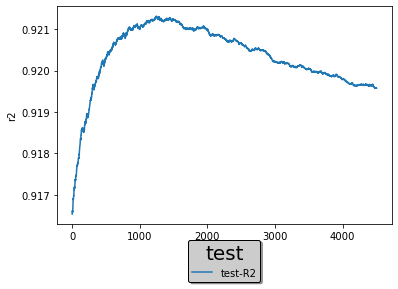

In [43]:
#plt.figure(figsize=(4, 2))
#plt.plot(np.squeeze(plot_dict_eval['train-R2'][50:]),label = 'train-R2')
plt.plot(np.squeeze(plot_dict_eval['test-R2'][500:]),label = 'test-R2')
plt.legend(
    loc='upper center', bbox_to_anchor=(0.5, -0.05),
    fontsize=10,
    shadow=True,
    facecolor='#ccc',
    edgecolor='#000',
    title='test',
    title_fontsize=20)
plt.ylabel('r2')
plt.xlabel('iterations')
plt.show()

In [34]:
from graphviz import Digraph
from xgboost import plot_tree
import matplotlib.pyplot as plt

# 創建呈現在每一棵樹上的feature name
def create_feature_map(features):
    outfile = open("xgb.fmap", "w")
    i = 0
    for feat in features:
        outfile.write("{0}\t{1}\tq\t".format(i, feat))
        i = i+1
    outfile.close

create_feature_map(X_train.columns)
plot_tree(xgb, # 引入上面訓練好的xgb model 
          num_trees=0, # 第幾棵樹
          fmap="xgb.fmap") # 引入feature name

fig = plt.gcf()
fig.set_size_inches(570, 380)

plt.show()


NameError: name 'xgb' is not defined

In [22]:
# xgb = xgboost.XGBRegressor(**params)
# xgb.fit(X_train,y_train, eval_set=[(X_test, y_test)],verbose=False)
# score = xgb.score(X_test,y_test)
# predictions = xgb.predict(X_test)
# mse = ((predictions - y_test)**2).sum()
# print("mape = ",abs((predictions - y_test)/y_test).sum())
# print("r2 = ",score)
# print("sqrt(mse) = ",math.sqrt(mse/len(predictions)))

mape =  962.360937785828
r2 =  0.8711603068471903
sqrt(mse) =  1938565.195287849


In [49]:
# for i in range(len(grid.cv_results_['rank_test_score'])):
#     print('{:3d}'.format(grid.cv_results_['rank_test_score'][i]),end = '')
#     if grid.cv_results_['rank_test_score'][i] < 10:
#         print('_',end = '')
#     else:
#         print(' ',end = '')
#     if i%9 == 8:
#         print()

 33  32  31  27   8_ 28  15   6_  3_ 22  10  26   7_ 18   2_ 14  29  23  25  17   5_ 11  19   1_  4_ 30   9_ 13  12  21  24  20 
 16 

In [7]:


#for grid search cv
# params = {'learning_rate': 0.1, 'n_estimators': 16, 'max_depth': 10, 'min_child_weight': 1, 'seed': 0,
#                     'subsample': 0.87, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 16, 'reg_lambda': 1,"early_stopping_rounds":20}

# xgb = xgboost.XGBRegressor(**params)



In [78]:
#old grid search cv
# grid = sklearn.model_selection.GridSearchCV(estimator=xgb, param_grid=cv_params, scoring='r2', verbose=4,cv = cv)

# grid.fit(X_train, y_train,
#         eval_set=[(X_train,y_train)],
#         verbose=False)
# print('参数的最佳取值：{0}'.format(grid.best_params_))
# print('最佳模型得分:{0}'.format(grid.best_score_))
# print(grid.cv_results_['rank_test_score'])
# print(grid.cv_results_)

Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV 1/2] END .....................learning_rate=1;, score=nan total time=   0.0s
[CV 2/2] END ..................learning_rate=1;, score=-1.910 total time=   0.0s
[CV 1/2] END .....................learning_rate=2;, score=nan total time=   0.0s
[CV 2/2] END ..................learning_rate=2;, score=-0.209 total time=   0.0s


C:\Users\chuang\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\chuang\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\chuang\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan]
  warnings.warn(


参数的最佳取值：{'learning_rate': 1}
最佳模型得分:nan
[1 2]
{'mean_fit_time': array([0.04458737, 0.04631114]), 'std_fit_time': array([0.00203395, 0.00075769]), 'mean_score_time': array([0.00200081, 0.00150001]), 'std_score_time': array([0.0010004 , 0.00050032]), 'param_learning_rate': masked_array(data=[1, 2],
             mask=[False, False],
       fill_value='?',
            dtype=object), 'params': [{'learning_rate': 1}, {'learning_rate': 2}], 'split0_test_score': array([nan, nan]), 'split1_test_score': array([-1.91016906, -0.20859275]), 'mean_test_score': array([nan, nan]), 'std_test_score': array([nan, nan]), 'rank_test_score': array([1, 2])}
